# Domain Adversarial Neural Networks (DANN)

This is the implementation for the following paper:
```
@article{ganin2016domain,
  title={Domain-adversarial training of neural networks},
  author={Ganin, Yaroslav and Ustinova, Evgeniya and Ajakan, Hana and Germain, Pascal and Larochelle, Hugo and Laviolette, Fran{\c{c}}ois and March, Mario and Lempitsky, Victor},
  journal={Journal of machine learning research},
  volume={17},
  number={59},
  pages={1--35},
  year={2016}
}
```

The paper is also available [here](./res/Domain-Adversarial%20Training%20of%20Neural%20Networks.pdf).

### Import libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from torchinfo import summary

from torch.utils.tensorboard import SummaryWriter

np.random.seed(0)
torch.manual_seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [2]:
import _base_model
import _dataloader_helper

#### For logging multiple runs

In [3]:
import pathlib

log_root = pathlib.Path(f'./dann')
run_id = 1
while True:
    log_dir = log_root/f'run{run_id}'
    if not log_dir.exists():
        break
    run_id += 1

# use a previous run
# log_dir = log_root/'run1'
log_dir.mkdir(parents=True, exist_ok=True)
print(f'Logging to: {log_dir}')

Logging to: dann\run3


### Prepare dataset

Here, we transform both the source and target datasets into the same size, and repeat the channel dimension for grayscale images, such that both datasets have the same input shape to the model.

In [4]:
input_shape = (3, 32, 32)
num_classes = 10

loader_helper = _dataloader_helper.MNIST2USPS(image_size=input_shape[1:])
src_train, src_val, src_test = loader_helper.get_src_loaders()
tgt_train, tgt_val, tgt_test = loader_helper.get_tgt_loaders()

#### Visualize some samples from both domains

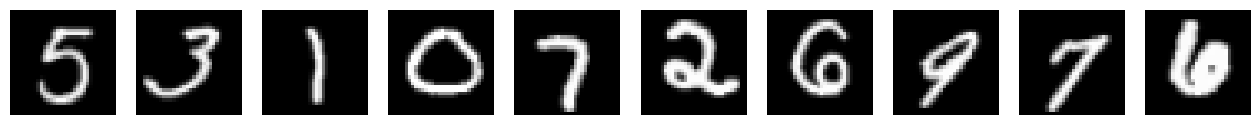

torch.Size([10, 3, 32, 32])
tensor([5, 3, 1, 0, 7, 2, 6, 9, 7, 6])


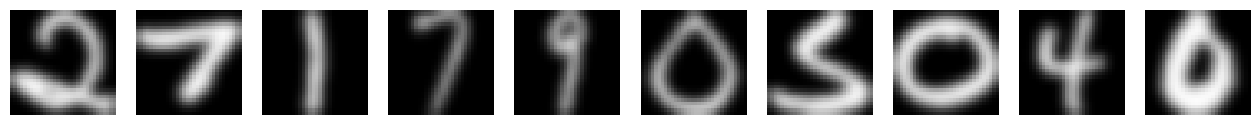

torch.Size([10, 3, 32, 32])
tensor([2, 7, 1, 7, 9, 0, 5, 0, 4, 0])


In [5]:
num_samples = 10

src_samples = next(iter(src_train))
tgt_samples = next(iter(tgt_train))

src_images, src_labels = src_samples[0][:num_samples], src_samples[1][:num_samples]
tgt_images, tgt_labels = tgt_samples[0][:num_samples], tgt_samples[1][:num_samples]

def plot_samples(samples, figsize=(16, 6)):
    fig, ax = plt.subplots(1, num_samples, figsize=figsize)
    for i in range(num_samples):
        ax[i].imshow(np.transpose(samples[i], (1, 2, 0)))
        ax[i].axis('off')
    plt.show()

plot_samples(src_images)
print(src_images.shape)
print(src_labels)

plot_samples(tgt_images)
print(tgt_images.shape)
print(tgt_labels)

## DANN

The general architecture of DANN is shown in the figure below:<br>
<img src="./res/images/dann-overview.png" width="1000">

The objective function of DANN is similar to that of ADDA in the sense that they both contain adversarial terms, in which the label predictor is encouraged to fool the domain classifier and the domain classifier is encouraged to correctly discriminate between the domains. However, DANN performs domain adpatation during the training of the classifier (i.e. end-to-end), while ADDA performs adaptation in a separate step after training the source classifier.

The loss function of DANN is defined as follows:
\begin{align*}
E(\theta_f, \theta_y, \theta_d) &= \sum_{i, d_i=0} L_y(G_y(G_f(\mathbf{x}_i; \theta_f); \theta_y), y_i) - \lambda \sum_{i} L_d(G_d(G_f(\mathbf{x}_i; \theta_f); \theta_d), d_i) \\
    &= \sum_{i, d_i=0} L_y^i(\theta_f, \theta_y) - \lambda \sum_{i} L_d^i(\theta_f, \theta_d)
\end{align*}
where $L_y$ is the label prediction loss, $L_d$ is the domain classification loss, $G_f$ is the feature extractor, $G_y$ is the label predictor, and $G_d$ is the domain classifier. And $\lambda$ is a hyperparameter that balances the two losses.

The objective is then to find parameters $\hat{\theta}_f$, $\hat{\theta}_y$, and $\hat{\theta}_d$ such that:
\begin{align*}
\hat{\theta}_f, \hat{\theta}_y &= \arg\min_{\theta_f, \theta_y} E(\theta_f, \theta_y, \hat{\theta}_d) \\
\hat{\theta}_d &= \arg\max_{\theta_d} E(\hat{\theta}_f, \hat{\theta}_y, \theta_d)
\end{align*}

### Build our model

In [6]:
class GradientReversalF(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.alpha, None

In [7]:
class DANNModel(nn.Module):
    def __init__(self, input_shape, num_classes):
        super().__init__()

        self.encoder = _base_model.CNNEncoder(
            input_shape=input_shape
        )
        self.cls_head = _base_model.FCHead(
            input_shape=self.encoder.output_shape,
            op_out_features=num_classes
        )
        self.domain_cls_head = _base_model.FCHead(
            input_shape=self.encoder.output_shape,
            op_out_features=2
        )
    
    def forward(self, x, alpha=1):
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)
        x_reverse = GradientReversalF.apply(x, alpha)
        y_pred = self.cls_head(x)
        d_pred = self.domain_cls_head(x_reverse)
        return (y_pred, d_pred)

In [8]:
model = DANNModel(
    input_shape=input_shape,
    num_classes=num_classes
).to(device)

summary(model, input_size=(5, *input_shape))

Layer (type:depth-idx)                   Output Shape              Param #
DANNModel                                [5, 10]                   --
├─CNNEncoder: 1-1                        [5, 128, 2, 2]            --
│    └─ModuleList: 2-1                   --                        --
│    │    └─Sequential: 3-1              [5, 64, 15, 15]           1,792
│    │    └─Sequential: 3-2              [5, 128, 6, 6]            73,856
│    │    └─Sequential: 3-3              [5, 128, 2, 2]            147,584
├─FCHead: 1-2                            [5, 10]                   --
│    └─ModuleList: 2-2                   --                        --
│    │    └─Sequential: 3-4              [5, 3072]                 1,575,936
│    │    └─Sequential: 3-5              [5, 2048]                 6,293,504
│    │    └─Linear: 3-6                  [5, 10]                   20,490
├─FCHead: 1-3                            [5, 2]                    --
│    └─ModuleList: 2-3                   --            

### Train the model

In [9]:
def evaluate(model, val_loader, loss_fn):
    val_loss = 0
    val_acc = 0

    training = model.training
    model.eval()
    with torch.no_grad():
        for batch, (x, y) in enumerate(val_loader):
            x, y = x.to(device), y.to(device)
            y_pred, _ = model(x)
            loss = loss_fn(y_pred, y).item()
            n_correct = (y_pred.argmax(dim=1) == y).sum().item()
            val_loss += loss * x.shape[0]
            val_acc += n_correct
    model.train(training)
    
    val_loss /= len(val_loader.dataset)
    val_acc /= len(val_loader.dataset)
    return (val_loss, val_acc)

def train(
    model,
    src_loader,
    tgt_loader,
    src_val_loader,
    tgt_val_loader,
    loss_fn,
    optimizer,
    num_steps=20000,
    checkpoint=100,
):
    model.train()

    train_stats = []
    val_stats = []
    best_val_loss = float('inf')

    src_loader_iter = iter(src_loader)
    tgt_loader_iter = iter(tgt_loader)

    tb_writer = SummaryWriter(log_dir=log_dir)

    for step in tqdm(range(num_steps)):
        try:
            src_x, src_y = next(src_loader_iter)
        except StopIteration:
            src_loader_iter = iter(src_loader)
            src_x, src_y = next(src_loader_iter)
        try:
            tgt_x, tgt_y = next(tgt_loader_iter)
        except StopIteration:
            tgt_loader_iter = iter(tgt_loader)
            tgt_x, tgt_y = next(tgt_loader_iter)
        
        src_x, src_y = src_x.to(device), src_y.to(device)
        tgt_x, tgt_y = tgt_x.to(device), tgt_y.to(device)

        alpha = 2 / (1 + np.exp(-10 * step/num_steps)) - 1

        src_y_pred, src_d_pred = model(src_x, alpha=alpha)
        tgt_y_pred, tgt_d_pred = model(tgt_x, alpha=alpha)

        # src domain samples are labeled 0, tgt domain samples are labeled 1
        srd_d = torch.full((src_x.shape[0],), fill_value=0, dtype=torch.long, device=device)
        tgt_d = torch.full((tgt_x.shape[0],), fill_value=1, dtype=torch.long, device=device)

        # note that we do not use tgt_y
        src_L_y = loss_fn(src_y_pred, src_y)
        src_L_d = loss_fn(src_d_pred, srd_d)
        tgt_L_d = loss_fn(tgt_d_pred, tgt_d)
        loss = src_L_y + src_L_d + tgt_L_d

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % checkpoint == 0:
            src_val_loss, src_val_acc = evaluate(model, src_val_loader, loss_fn)
            tgt_val_loss, tgt_val_acc = evaluate(model, tgt_val_loader, loss_fn)

            train_stats += [[
                step,
                loss.item(),
                src_L_y.item(),
                src_L_d.item(),
                tgt_L_d.item(),
            ]]
            val_stats += [[
                step,
                src_val_loss,
                src_val_acc,
                tgt_val_loss,
                tgt_val_acc,
            ]]

            tb_writer.add_scalar('train/loss', loss.item(), step)
            tb_writer.add_scalar('train/src_L_y', src_L_y.item(), step)
            tb_writer.add_scalar('train/src_L_d', src_L_d.item(), step)
            tb_writer.add_scalar('train/tgt_L_d', tgt_L_d.item(), step)

            tb_writer.add_scalar('val/src_L_y', src_val_loss, step)
            tb_writer.add_scalar('val/src_acc', src_val_acc, step)
            tb_writer.add_scalar('val/tgt_L_d', tgt_val_loss, step)
            tb_writer.add_scalar('val/tgt_acc', tgt_val_acc, step)

            # save the best model
            # this may be cheating since in reality the target dataset is unlabeled
            if tgt_val_loss < best_val_loss:
                best_val_loss = tgt_val_loss
                torch.save(model.state_dict(), log_dir/'tgt_best_model.pth')

    tb_writer.close()

    train_stats = np.array(train_stats)
    val_stats = np.array(val_stats)
    return (train_stats, val_stats)

In [10]:
train_stats, val_stats = train(
    model,
    src_train,
    tgt_train,
    src_val,
    tgt_val,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.5, 0.9)),
    num_steps=5000,
    checkpoint=100,
)

100%|██████████| 5000/5000 [05:52<00:00, 14.17it/s]


### Learning curves

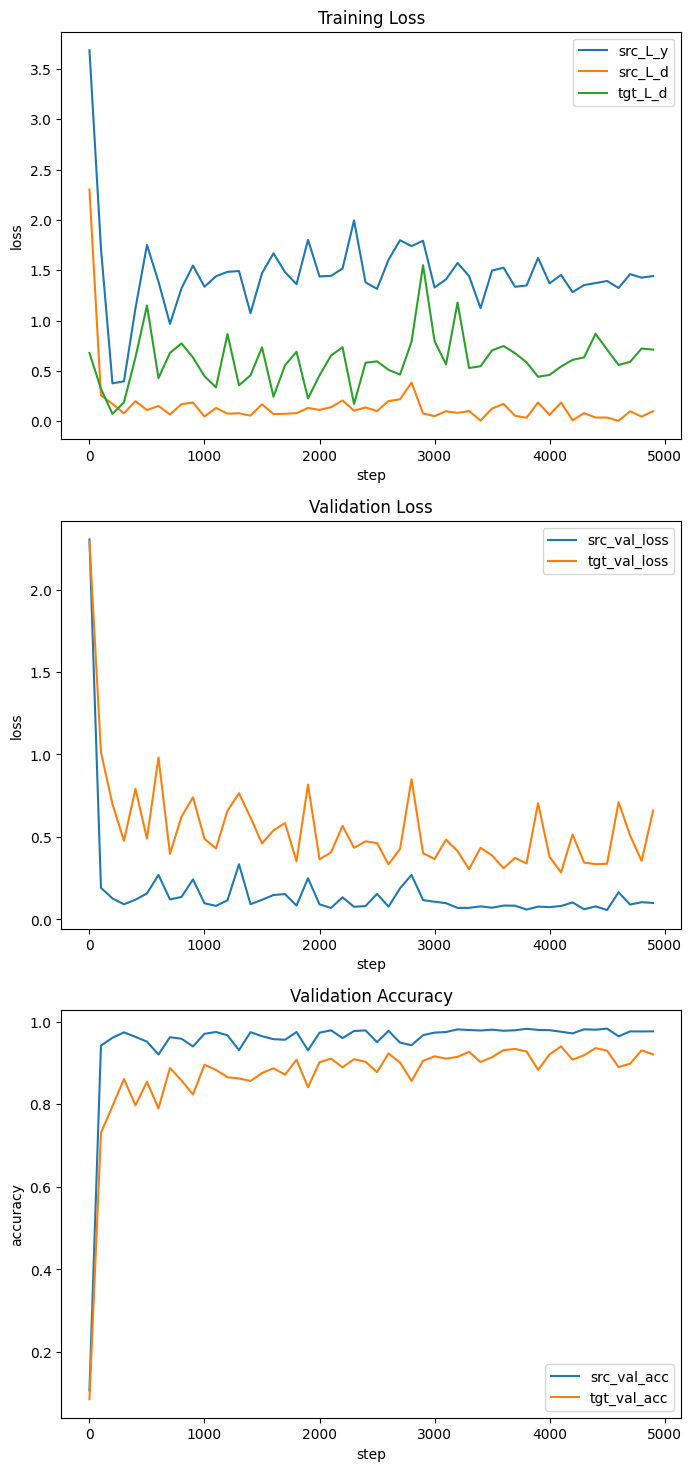

In [11]:
plt.figure(figsize=(8, 18))
plt.subplot(3, 1, 1)
plt.plot(train_stats[:, 0], train_stats[:, 1], label='src_L_y')
plt.plot(train_stats[:, 0], train_stats[:, 2], label='src_L_d')
plt.plot(train_stats[:, 0], train_stats[:, 3], label='tgt_L_d')
plt.legend()
plt.xlabel('step')
plt.ylabel('loss')
plt.title('Training Loss')

plt.subplot(3, 1, 2)
plt.plot(val_stats[:, 0], val_stats[:, 1], label='src_val_loss')
plt.plot(val_stats[:, 0], val_stats[:, 3], label='tgt_val_loss')
plt.legend()
plt.xlabel('step')
plt.ylabel('loss')
plt.title('Validation Loss')

plt.subplot(3, 1, 3)
plt.plot(val_stats[:, 0], val_stats[:, 2], label='src_val_acc')
plt.plot(val_stats[:, 0], val_stats[:, 4], label='tgt_val_acc')
plt.legend()
plt.xlabel('step')
plt.ylabel('accuracy')
plt.title('Validation Accuracy')
plt.show()

### Evaluate the best model

In [12]:
model.load_state_dict(torch.load(log_dir/'tgt_best_model.pth'))

src_loss, src_acc = evaluate(model, src_test, nn.CrossEntropyLoss())
tgt_loss, tgt_acc = evaluate(model, tgt_test, nn.CrossEntropyLoss())

print('Adapted model:')
print(f'src_test -> loss: {src_loss:.4f}, acc: {src_acc:.4f}')
print(f'tgt_test -> loss: {tgt_loss:.4f}, acc: {tgt_acc:.4f}')

Adapted model:
src_test -> loss: 0.0663, acc: 0.9810
tgt_test -> loss: 0.4282, acc: 0.9108
